CIFAR10 dataset split into neg/pos and trained using normal CNN without augmentation.  
- Class weighting  

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'cnn',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['ship'],
    "num_epochs": 15,
    "batch_size": 64,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "learning_rate": 0.01,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 0 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 0 1 1 1 1]
[1 0 0 1 1 1 1 1 1 1]
[1 1 0 1 1 0 1 1 1 1]
[1 1 0 1 0 0 0 1 0 1]
[1 1 1 1 1 1 1 1 1 1]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [4]:
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.00
Weight for class 1: 0.56


# Training

### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [5]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import datetime

In [6]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=config['img_shape']))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(1, activation='sigmoid'))
# cnn_model.add(layers.Dense(params['num_classes'], activation='softmax'))

In [7]:
if config['verbosity'] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [9]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

cnn_model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics)

In [10]:
log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]

In [11]:
history = cnn_model.fit(
    train_ds,
    steps_per_epoch = params["train_size"] // config["batch_size"],
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = params["test_size"] // config["batch_size"],
    validation_freq = 1
#     class_weight=class_weight
#     callbacks = callbacks
)

Train for 546 steps, validate for 117 steps
Epoch 1/15
546/546 [==============================] - 7s 12ms/step - loss: 0.2363 - true_positives: 30813.0000 - false_positives: 2508.0000 - true_negatives: 961.0000 - false_negatives: 662.0000 - binary_accuracy: 0.9093 - precision: 0.9247 - recall: 0.9790 - auc: 0.8880 - val_loss: 0.3142 - val_true_positives: 6624.0000 - val_false_positives: 579.0000 - val_true_negatives: 217.0000 - val_false_negatives: 68.0000 - val_binary_accuracy: 0.9136 - val_precision: 0.9196 - val_recall: 0.9898 - val_auc: 0.8602
Epoch 2/15
546/546 [==============================] - 4s 7ms/step - loss: 0.1700 - true_positives: 30871.0000 - false_positives: 1743.0000 - true_negatives: 1724.0000 - false_negatives: 606.0000 - binary_accuracy: 0.9328 - precision: 0.9466 - recall: 0.9807 - auc: 0.9377 - val_loss: 0.1716 - val_true_positives: 6508.0000 - val_false_positives: 283.0000 - val_true_negatives: 511.0000 - val_false_negatives: 186.0000 - val_binary_accuracy: 0.937

`Keras`
Save/load the model

In [ ]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

In [113]:
from sklearn.metrics import confusion_matrix

Some functions

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [117]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

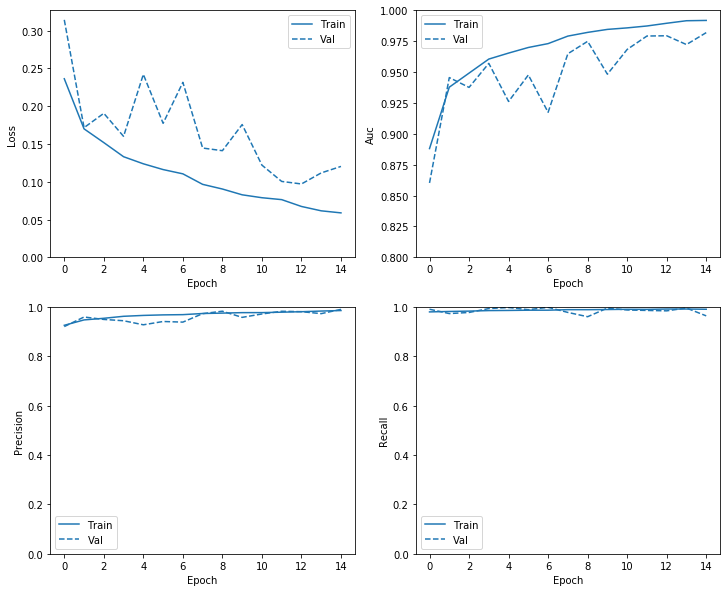

In [24]:
plot_metrics(history)

In [121]:
cnn_results = cnn_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["batch_size"])
print()

f = open(log_dir+"/evaluate.txt","w")
for name, value in zip(cnn_model.metrics_names, cnn_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()

117/117 - 0s - loss: 0.1077 - true_positives: 6525.0000 - false_positives: 62.0000 - true_negatives: 673.0000 - false_negatives: 228.0000 - binary_accuracy: 0.9613 - precision: 0.9906 - recall: 0.9662 - auc: 0.9821

loss : 0.10769334843016079
true_positives : 6525.0
false_positives : 62.0
true_negatives : 673.0
false_negatives : 228.0
binary_accuracy : 0.961271345615387
precision : 0.9905875325202942
recall : 0.9662372469902039
auc : 0.9821393489837646


In [119]:
plot_cm(test_labels, test_predictions_baseline)

NameError: name 'test_labels' is not defined

`Tensorboard`

## Predict new samples

In [27]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.9979 | 1.0
Image 54 of 64


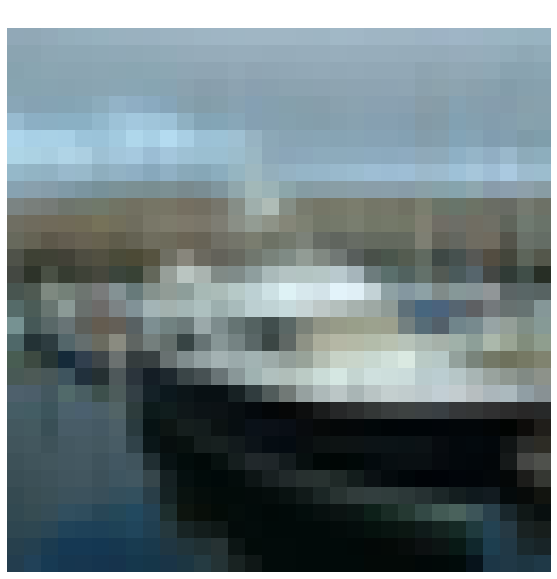

In [71]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

print("{:0.4f} | {}".format(pred, np.round(pred)))

prediction = ('Boat') if np.round(pred)==0 else ('Not boat')

print ("Image {} of {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [110]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, prediction in enumerate(predictions.flat):
    print ('\n{:3}  {:.3f}  {:.3f}'.format(i, labels[i], prediction), end='')
    if (int(labels[i]) != int(np.round(prediction))): print (" -Wrong", end='')

idx  label  pred
---  -----  ----

  0  1.000  1.000
  1  1.000  0.995
  2  1.000  0.931
  3  1.000  0.949
  4  1.000  0.997
  5  1.000  1.000
  6  1.000  1.000
  7  1.000  1.000
  8  1.000  1.000
  9  1.000  1.000
 10  1.000  1.000
 11  1.000  0.188 -Wrong
 12  1.000  1.000
 13  1.000  1.000
 14  1.000  0.998
 15  1.000  1.000
 16  1.000  0.369 -Wrong
 17  1.000  0.999
 18  1.000  1.000
 19  1.000  1.000
 20  1.000  0.764
 21  1.000  1.000
 22  1.000  1.000
 23  1.000  0.998
 24  1.000  1.000
 25  1.000  1.000
 26  1.000  0.443 -Wrong
 27  1.000  1.000
 28  1.000  1.000
 29  1.000  1.000
 30  0.000  0.393
 31  1.000  1.000
 32  1.000  1.000
 33  0.000  0.942 -Wrong
 34  1.000  0.957
 35  1.000  1.000
 36  1.000  1.000
 37  1.000  0.998
 38  1.000  1.000
 39  1.000  1.000
 40  1.000  1.000
 41  1.000  0.998
 42  1.000  1.000
 43  1.000  1.000
 44  0.000  0.093
 45  1.000  1.000
 46  1.000  1.000
 47  1.000  1.000
 48  1.000  1.000
 49  1.000  1.000
 50  1.000  1.000
 51  1.000  1.000
 